# Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import logging

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.ensemble import RandomForestClassifier 
from sklearn.metrics import accuracy_score 
from sklearn.model_selection import GridSearchCV, cross_val_score

import tensorflow as tf
from tensorflow.keras.models import Sequential # type: ignore
from tensorflow.keras.layers import LSTM, Dense # type: ignore
from tensorflow.keras.preprocessing.sequence import pad_sequences # type: ignore
from tensorflow.keras.preprocessing.text import Tokenizer # type: ignore

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

from sentence_transformers import SentenceTransformer
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess
import nltk
import re
import string
import spacy
import contractions

import shap


c:\Users\guigr\anaconda3\envs\tfm\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Vectorización TF-IDF + Redes Neuronales MLPs

Aunque el Random Forest ha logrado una precisión del 98.4% en la detección de noticias falsas, es valioso explorar el desempeño de **redes neuronales**, ya que pueden capturar patrones complejos en los datos. 

En primer lugar, utilizaremos la misma vectorización TF-IDF, evaluaremos si modelos neuronales ofrecen ventajas adicionales en términos de generalización y robustez. 

Más tarde, probaremos con otras **formas de vectorización**. 

Para terminar, exploraremos si **redes neuronales recurrentes** (RNNs) ofrecen un rendimiento superior al capturar dependencias secuenciales y contextuales en los textos.

## División en Train, Validation & Test para Redes Neuronales

In [ ]:
# Cargar el DataFrame limpio
df = pd.read_csv("Datasets/Cleaned-FR-News_V2.csv")

# Dividimos los datos en entrenamiento y prueba
# Por ahora usaremos únicamente el texto de la noticia (omitimos el título)
X = df["clean_text"]
y = df["label"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Se usará para redes neuronales
# Usaremos un 20% del conjunto de datos para validación (16% del total)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [ ]:
print("Shape of X_train:", X_train.shape)
print("Shape of X_valid:", X_valid.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_valid:", y_valid.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_train: (28283,)
Shape of X_valid: (7071,)
Shape of X_test: (8839,)
Shape of y_train: (28283,)
Shape of y_valid: (7071,)
Shape of y_test: (8839,)


##  Vectorización mediante TF-IDF + Red Neuronal MLP

#### Tokenización y Tensorización

In [ ]:
# Definir y ajustar el vectorizador TF-IDF en el conjunto de entrenamiento
vectorizer = TfidfVectorizer(max_features=5000)
X_train = vectorizer.fit_transform(X_train)

# Transformar los conjuntos de validación y prueba utilizando el vectorizador ajustado
X_valid = vectorizer.transform(X_valid)
X_test = vectorizer.transform(X_test)

# Verificar las dimensiones de los conjuntos transformados
print("Shape of X_train_tfidf:", X_train.shape)
print("Shape of X_valid_tfidf:", X_valid.shape)
print("Shape of X_test_tfidf:", X_test.shape)

Shape of X_train_tfidf: (28283, 5000)
Shape of X_valid_tfidf: (7071, 5000)
Shape of X_test_tfidf: (8839, 5000)


In [ ]:
# Convertir datos a tensores de PyTorch
def tensorize(data, labels, device):
    data_tensor = torch.tensor(data.toarray(), dtype=torch.float32).to(device)
    labels_tensor = torch.tensor(labels.values, dtype=torch.float32).unsqueeze(1).to(device)
    return data_tensor, labels_tensor

In [ ]:
# Verificar si la GPU está disponible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Tensorizar los conjuntos de datos
X_train_tensor, y_train_tensor = tensorize(X_train, y_train, device)
X_valid_tensor, y_valid_tensor = tensorize(X_valid, y_valid, device)
X_test_tensor, y_test_tensor = tensorize(X_test, y_test, device)

print("Shape of X_train_tensor:", X_train_tensor.shape)
print("Shape of y_train_tensor:", y_train_tensor.shape)
print("Shape of X_valid_tensor:", X_valid_tensor.shape)
print("Shape of y_valid_tensor:", y_valid_tensor.shape)

Using device: cuda
Shape of X_train_tensor: torch.Size([28283, 5000])
Shape of y_train_tensor: torch.Size([28283, 1])
Shape of X_valid_tensor: torch.Size([7071, 5000])
Shape of y_valid_tensor: torch.Size([7071, 1])


In [ ]:
# Create DataLoaders para entrenamiento y validación
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
valid_dataset = TensorDataset(X_valid_tensor, y_valid_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Variables de configuración
batch_size = 128

# Crear DataLoaders para entrenamiento y validación
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

#### Definición del modelo

In [ ]:
# Definimos modelo MLP
mlp_model = nn.Sequential(
    nn.Linear(5000, 128),
    nn.ReLU(),
    nn.Linear(128, 64),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(64, 1),
    nn.Sigmoid()
)

#### Funciones para entrenamiento y validación

In [ ]:
def train_model(model, train_loader, valid_loader, criterion, optimizer, num_epochs, device, best_model_path):
    train_losses, valid_losses = [], []
    train_accuracies, valid_accuracies = [], []
    best_val_loss = float("inf")

    # Entrenamiento
    for epoch in range(num_epochs):
        model.train()
        train_loss, correct_train, total_train = 0, 0, 0

        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            predicted = (outputs >= 0.5).float()
            correct_train += (predicted == y_batch).sum().item()
            total_train += y_batch.size(0)

        train_losses.append(train_loss / len(train_loader))
        train_accuracies.append(correct_train / total_train)

        # Validation
        model.eval()
        valid_loss, correct_valid, total_valid = 0, 0, 0

        with torch.no_grad():
            for X_batch, y_batch in valid_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)
                valid_loss += loss.item()
                predicted = (outputs >= 0.5).float()
                correct_valid += (predicted == y_batch).sum().item()
                total_valid += y_batch.size(0)

        valid_losses.append(valid_loss / len(valid_loader))
        valid_accuracies.append(correct_valid / total_valid)

        # Guardar el mejor modelo
        if valid_losses[-1] < best_val_loss:
            best_val_loss = valid_losses[-1]
            torch.save(model.state_dict(), best_model_path)
            print(f"🔹 Saved best model at {best_model_path} (Val Loss: {best_val_loss:.4f})")

        print(f"Epoch [{epoch+1}/{num_epochs}] - Loss: {train_losses[-1]:.4f} - Acc: {train_accuracies[-1]:.4f} - Val Loss: {valid_losses[-1]:.4f} - Val Acc: {valid_accuracies[-1]:.4f}")

    return train_losses, valid_losses, train_accuracies, valid_accuracies

In [ ]:
def plot_loss_and_accuracy(train_losses, valid_losses, train_accuracies, valid_accuracies):
    """
    Function to plot training and validation loss and accuracy over epochs.

    Parameters:
    - train_losses: List of training losses for each epoch.
    - valid_losses: List of validation losses for each epoch.
    - train_accuracies: List of training accuracies for each epoch.
    - valid_accuracies: List of validation accuracies for each epoch.
    """
    plt.figure(figsize=(12, 5))

    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label="Train Loss")
    plt.plot(valid_losses, label="Val Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Loss over epochs")
    plt.legend()

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label="Train Acc")
    plt.plot(valid_accuracies, label="Val Acc")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title("Accuracy over epochs")
    plt.legend()

    plt.show()

In [ ]:
def evaluate_model(model, test_loader, device):
    """
    Evaluate the model on the test set using a DataLoader to avoid memory issues.

    Parameters:
    - model: The trained PyTorch model.
    - test_loader: DataLoader for the test set.
    - device: The device (CPU/GPU) to use for computation.

    Returns:
    - test_accuracy: Accuracy of the model on the test set.
    """
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch = X_batch.to(device)
            outputs = model(X_batch)
            preds = (outputs >= 0.5).float().cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(y_batch.cpu().numpy())

    # Calculate accuracy
    test_accuracy = accuracy_score(all_labels, all_preds)
    print(f"Precisión en el conjunto de prueba: {test_accuracy:.4f}")


#### Entrenamiento y validación

🔹 Saved best model at models/best_mlp.pth (Val Loss: 0.0632)
Epoch [1/10] - Loss: 0.2038 - Acc: 0.9450 - Val Loss: 0.0632 - Val Acc: 0.9788
🔹 Saved best model at models/best_mlp.pth (Val Loss: 0.0550)
Epoch [2/10] - Loss: 0.0341 - Acc: 0.9900 - Val Loss: 0.0550 - Val Acc: 0.9818
Epoch [3/10] - Loss: 0.0147 - Acc: 0.9961 - Val Loss: 0.0564 - Val Acc: 0.9829
Epoch [4/10] - Loss: 0.0068 - Acc: 0.9987 - Val Loss: 0.0604 - Val Acc: 0.9827
Epoch [5/10] - Loss: 0.0028 - Acc: 0.9998 - Val Loss: 0.0663 - Val Acc: 0.9819
Epoch [6/10] - Loss: 0.0013 - Acc: 0.9999 - Val Loss: 0.0819 - Val Acc: 0.9826
Epoch [7/10] - Loss: 0.0006 - Acc: 1.0000 - Val Loss: 0.0856 - Val Acc: 0.9826
Epoch [8/10] - Loss: 0.0004 - Acc: 1.0000 - Val Loss: 0.0885 - Val Acc: 0.9827
Epoch [9/10] - Loss: 0.0002 - Acc: 1.0000 - Val Loss: 0.0918 - Val Acc: 0.9823
Epoch [10/10] - Loss: 0.0002 - Acc: 1.0000 - Val Loss: 0.0937 - Val Acc: 0.9830


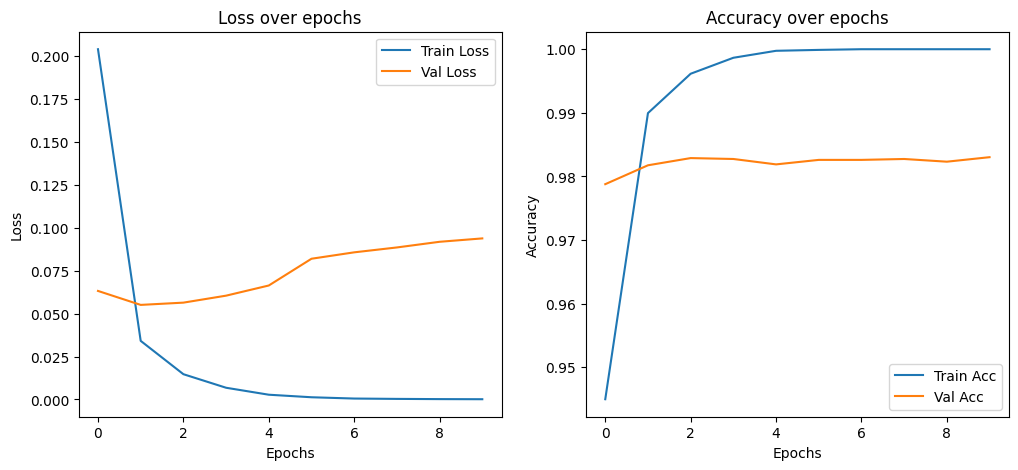

Precisión en el conjunto de prueba: 0.9848


In [ ]:
# Instanciar modelo y moverlo a GPU si está disponible
model = mlp_model.to(device)

# Función de pérdida y optimizador
criterion = nn.BCELoss()  # Pérdida para clasificación binaria
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Variables de ntrenamiento
num_epochs = 10
train_losses, valid_losses = [], []
train_accuracies, valid_accuracies = [], []

# Ruta donde se guardará el mejor modelo
best_model_path = "models/best_mlp.pth"  

# Entrenar el modelo
train_losses, valid_losses, train_accuracies, valid_accuracies = train_model(
    model, train_loader, valid_loader, criterion, optimizer, num_epochs, device, best_model_path
)

# Graficar pérdidas y precisiones
plot_loss_and_accuracy(train_losses, valid_losses, train_accuracies, valid_accuracies)

# Evaluar el modelo en el conjunto de prueba
evaluate_model(model, test_loader, device)

El modelo ha mostrado un rendimiento sobresaliente, alcanzando una precisión en validación cercana al 98.2% y una pérdida de 0.05 tras solo **tres épocas**. En el conjunto de prueba, se obtuvo el mejor desempeño con una precisión del **98.5%**.

## Vectorización mediante Embeddings (*BERT*) + Red Neuronal MLP

En lugar de utilizar **TF-IDF** como vectorización inicial, vamos a probar con embeddings como **BERT**, pues podría ser una excelente idea al capturar mejor el significado semántico del texto completo, a diferencia de TF-IDF, que se basa en la frecuencia de palabras y carece de contexto.
 
Además, BERT reduce significativamente la **dimensionalidad** (768 vs 5000), al mismo tiempo que captura relaciones más profundas en el texto, lo que puede optimizar la eficiencia computacional y reducir el riesgo de sobreajuste.

Por otro lado, al usar **sentence-transformers** se obtiene una **única representación fija para cada noticia**, lo que hace incompatible el uso de LSTMs, ya que no se trabaja con secuencias de vectores por palabra, sino con un solo embedding por entrada.

#### Vectorización mediante *Sentence-transformers*

El model de embeddings que se va a utilizar, **bert-base-nli-mean-tokens**, presenta las siguientes características:

- **`bert-base`** → Está basado en el modelo BERT con 12 capas, 768 dimensiones ocultas y 12 cabezas de atención.
- **`nli` (Inferencia de Lenguaje Natural)** → El modelo fue ajustado con datasets de NLI (SNLI + MNLI) para entender relaciones semánticas entre oraciones.
- **`mean-tokens`** → Utiliza un promedio de los embeddings de todos los tokens para crear embeddings de oraciones, en lugar de usar solo el token `[CLS]`.

In [ ]:
# Cargar el DataFrame limpio
df = pd.read_csv("Datasets/Cleaned-FR-News_V2.csv")

# Dividimos los datos en entrenamiento y prueba
# Por ahora usaremos únicamente el texto de la noticia (omitimos el título)
X = df["clean_text"]
y = df["label"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Se usará para redes neuronales
# Usaremos un 20% del conjunto de datos para validación (16% del total)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

model = SentenceTransformer("bert-base-nli-mean-tokens") # Modelo rápido

# Convertir a embeddings
X_train_embedding = model.encode(X_train.tolist())
X_valid_embedding = model.encode(X_valid.tolist())
X_test_embedding = model.encode(X_test.tolist())

# Verificar las dimensiones de los conjuntos transformados
print("Shape of X_train_tfidf:", X_train.shape)
print("Shape of X_valid_tfidf:", X_valid.shape)
print("Shape of X_test_tfidf:", X_test.shape)

(28283, 768)

#### Entrenamiento y evaluación

🔹 Saved best model at models/best_mlp_embeddings.pth (Val Loss: 0.2037)
Epoch [1/20] - Loss: 0.2669 - Acc: 0.8901 - Val Loss: 0.2037 - Val Acc: 0.9192
🔹 Saved best model at models/best_mlp_embeddings.pth (Val Loss: 0.1752)
Epoch [2/20] - Loss: 0.1771 - Acc: 0.9323 - Val Loss: 0.1752 - Val Acc: 0.9320
🔹 Saved best model at models/best_mlp_embeddings.pth (Val Loss: 0.1622)
Epoch [3/20] - Loss: 0.1521 - Acc: 0.9427 - Val Loss: 0.1622 - Val Acc: 0.9349
🔹 Saved best model at models/best_mlp_embeddings.pth (Val Loss: 0.1435)
Epoch [4/20] - Loss: 0.1360 - Acc: 0.9474 - Val Loss: 0.1435 - Val Acc: 0.9441
🔹 Saved best model at models/best_mlp_embeddings.pth (Val Loss: 0.1340)
Epoch [5/20] - Loss: 0.1243 - Acc: 0.9528 - Val Loss: 0.1340 - Val Acc: 0.9485
Epoch [6/20] - Loss: 0.1198 - Acc: 0.9544 - Val Loss: 0.1576 - Val Acc: 0.9400
Epoch [7/20] - Loss: 0.1078 - Acc: 0.9587 - Val Loss: 0.1551 - Val Acc: 0.9419
🔹 Saved best model at models/best_mlp_embeddings.pth (Val Loss: 0.1215)
Epoch [8/20] - 

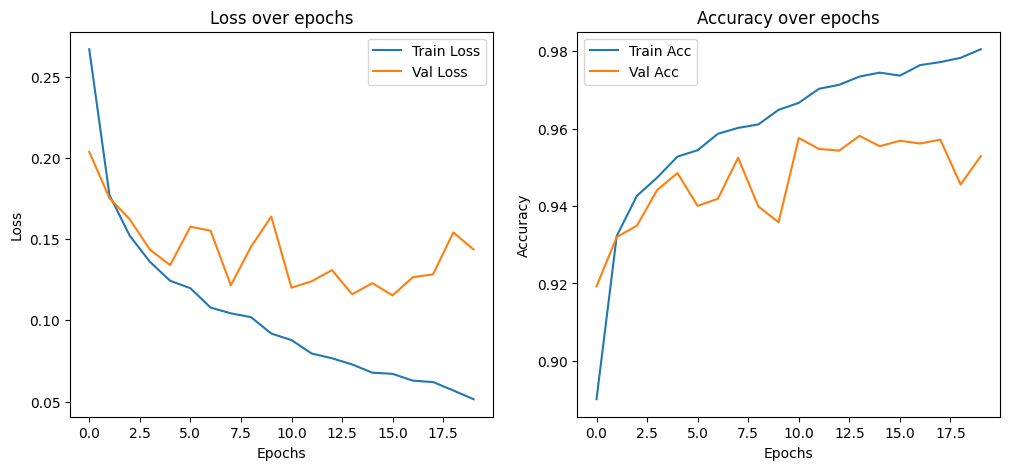

Precisión en el conjunto de prueba: 0.9628


In [ ]:
# GPU disponible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Convertir datos a tensores de PyTorch cuando ya son arrays
def tensorize_array(data, labels, device):
    data_tensor = torch.tensor(data, dtype=torch.float32).to(device)
    labels_tensor = torch.tensor(labels.values, dtype=torch.float32).unsqueeze(1).to(device)
    return data_tensor, labels_tensor

X_train_tensor, y_train_tensor = tensorize_array(X_train_embedding, y_train, device)
X_valid_tensor, y_valid_tensor = tensorize_array(X_valid_embedding, y_valid, device)
X_test_tensor, y_test_tensor = tensorize_array(X_test_embedding, y_test, device)

# Create DataLoaders para entrenamiento y validación
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
valid_dataset = TensorDataset(X_valid_tensor, y_valid_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Variables de configuración
batch_size = 128

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Definimos modelo MLP
mlp_model = nn.Sequential(
    nn.Linear(768, 128),
    nn.ReLU(),
    nn.Linear(128, 64),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(64, 1),
    nn.Sigmoid()
)

# Instanciar modelo y moverlo a GPU si está disponible
model = mlp_model.to(device)

# Función de pérdida y optimizador
criterion = nn.BCELoss()  # Pérdida para clasificación binaria
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Variables de ntrenamiento
num_epochs = 20
train_losses, valid_losses = [], []
train_accuracies, valid_accuracies = [], []

# Ruta donde se guardará el mejor modelo
best_model_path = "models/best_mlp_embeddings.pth"  

# Entrenar el modelo
train_losses, valid_losses, train_accuracies, valid_accuracies = train_model(
    model, train_loader, valid_loader, criterion, optimizer, num_epochs, device, best_model_path
)

# Graficar pérdidas y precisiones
plot_loss_and_accuracy(train_losses, valid_losses, train_accuracies, valid_accuracies)

# Evaluar el modelo en el conjunto de prueba
evaluate_model(model, test_loader, device)

No se observa un rendimiento superior comparando con el modelo que utilizaba vectorización TF-IDF como entrada de la MLP, obteniendo un **96.3%** de precisión en el conjunto de prueba.

La **MLP** con **TF-IDF** podría funcionar mejor en la clasificación de noticias porque TF-IDF enfatiza **términos clave** específicos de cada noticia, lo que ayuda a **diferenciar mejor** las categorías. En cambio, **BERT**, al generar embeddings densos y compactos de 768 dimensiones, puede perder detalles relevantes al **comprimir la información** en un espacio más reducido.

# Vectorización mediante Embeddings + LSTM

## ¿Por qué es una buena idea probar con una red LSTM?

La clasificación de fake news utilizando una **RNN (Recurrent Neural Network)** es una excelente idea debido a su capacidad para manejar **secuencias de texto** largas y complejas, lo cual es fundamental en el análisis de noticias. 

Las LSTM son especialmente efectivas para **capturar dependencias a largo plazo** en los datos, lo que permite identificar patrones y contextos importantes en las noticias, incluso cuando la información relevante está dispersa a lo largo del texto. 

Además, se escoge una red **LSTM (Long Short-Term Memory)** por su capacidad para mitigar el problema del desvanecimiento del gradiente, que afecta a otras redes neuronales recurrentes, lo que las hace muy adecuadas para procesar y clasificar textos de forma eficiente y precisa, mejorando la detección de desinformación en el proceso.

## División en Train, Validation & Test para Redes Neuronales

In [13]:
# Cargar el DataFrame limpio
df = pd.read_csv("Datasets/Cleaned-FR-News_V2.csv")

# Dividimos los datos en entrenamiento y prueba
# Por ahora usaremos únicamente el texto de la noticia (omitimos el título)
X = df["clean_text"]
y = df["label"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Se usará para redes neuronales
# Usaremos un 20% del conjunto de datos para validación (16% del total)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [14]:
print("Shape of X_train:", X_train.shape)
print("Shape of X_valid:", X_valid.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_valid:", y_valid.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_train: (28283,)
Shape of X_valid: (7071,)
Shape of X_test: (8839,)
Shape of y_train: (28283,)
Shape of y_valid: (7071,)
Shape of y_test: (8839,)


## Vectorización con Tokenizer + LSTM Básica

#### Tokenización y Tensorización

En cuanto a la vectorización de nuestras noticias, es importante destacar que **TF-IDF** se enfoca en ponderar la importancia de las palabras en los documentos, pero **no captura la secuencia temporal** ni el contexto de las palabras en el texto, lo que puede limitar el rendimiento en modelos que dependen de la información secuencial, como las LSTM.

Por esta razón, utilizaremos un tokenizador que **preserve el orden temporal**. En este caso, emplearemos el **Tokenizer** de *TensorFlow*, que convierte el texto en secuencias de índices enteros que representan palabras, manteniendo tanto el orden como la estructura temporal del texto.

El proceso que realiza **Tokenizer** es el siguiente:

- **Tokenización**: Primero, las noticias se dividen en palabras o subpalabras (*tokens*), y cada palabra se asigna a un número único (*índice*) dentro del vocabulario.

- **Vectorización**: El *Tokenizer* convierte cada noticia en una secuencia de índices que corresponden a las palabras en el vocabulario. Por ejemplo, como nuestro vocabulario tiene un tamaño de 5000 palabras, cada palabra en el texto se mapea a un número entre 0 y 4999.

Además, cada noticia, una vez convertida en una secuencia de índices, será transformada en una secuencia de exactamente **1256 elementos**. Esto se hace porque, de media, las noticias recogidas tenían una longitud media de 1656 palabras tras el preprocesado. Sin embargo, un número de elementos mayor podría empeorar el rendimiento del entrenamiento.

Todas las secuencias tendrán la misma longitud gracias a la función **pad_sequences** de *Tensorflow*, pues realiza dos acciones dependiendo de la longitud de la secuencia:
- Si la noticia tiene menos de 1256 palabras, se agrega padding (relleno) con ceros.
- Si la noticia tiene más de 1256 palabras, se trunca la secuenia para que tenga solo 1256 índices.

Por defecto, el padding y el truncado se realizan al inicio.



In [7]:
# --------------------
# Tokenización y secuencias
# --------------------
# Disponibilidad de GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Usando device: {device}")

# Número máximo de palabras a considerar en el vocabulario
max_words = 5000
# Longitud máxima de las secuencias - La media de longitud de los textos es 1656 aproximadamente
max_len = 1256

# Inicializar el tokenizador de TensorFlow con un vocabulario limitado y un token para palabras 'Out-Of-Vocabulary'
tokenizer = Tokenizer(num_words=max_words, oov_token='<OOV>')
# Ajustar el tokenizador al texto de entrenamiento
tokenizer.fit_on_texts(X_train)

# Convertir textos a secuencias de índices y aplicar padding
X_train_embedding = tokenizer.texts_to_sequences(X_train)
X_train_embedding = pad_sequences(X_train_embedding, maxlen=max_len)
X_valid_embedding = tokenizer.texts_to_sequences(X_valid)
X_valid_embedding = pad_sequences(X_valid_embedding, maxlen=max_len)
X_test_embedding = tokenizer.texts_to_sequences(X_test)
X_test_embedding = pad_sequences(X_test_embedding, maxlen=max_len)

# Convertir a tensores de PyTorch
X_train_tensor = torch.tensor(X_train_embedding, dtype=torch.long).to(device)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).unsqueeze(1).to(device)
X_valid_tensor = torch.tensor(X_valid_embedding, dtype=torch.long).to(device)
y_valid_tensor = torch.tensor(y_valid.values, dtype=torch.float32).unsqueeze(1).to(device)
X_test_tensor = torch.tensor(X_test_embedding, dtype=torch.long).to(device)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).unsqueeze(1).to(device)

print("Shape of X_train_tensor:", X_train_tensor.shape)
print("Shape of y_train_tensor:", y_train_tensor.shape)
print("Shape of X_valid_tensor:", X_valid_tensor.shape)
print("Shape of y_valid_tensor:", y_valid_tensor.shape)
print("Shape of X_test_tensor:", X_test_tensor.shape)
print("Shape of y_test_tensor:", y_test_tensor.shape)

# Batch Size
batch_size = 128

# Crear Datasets & DataLoaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_dataset = TensorDataset(X_valid_tensor, y_valid_tensor)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Usando device: cuda
Shape of X_train_tensor: torch.Size([28283, 1256])
Shape of y_train_tensor: torch.Size([28283, 1])
Shape of X_valid_tensor: torch.Size([7071, 1256])
Shape of y_valid_tensor: torch.Size([7071, 1])
Shape of X_test_tensor: torch.Size([8839, 1256])
Shape of y_test_tensor: torch.Size([8839, 1])


#### Definición del modelo

Para que el modelo **LSTM** funcione correctamente, es necesario que los datos de entrada tengan **tres dimensiones**. Actualmente, el tensor de entrenamiento tiene una forma de *torch.Size([28283, 1256])*, es decir, contiene secuencias de longitud 1256 para 28,283 muestras, pero aún le falta la dimensión correspondiente a la representación vectorial de cada palabra.

Esta tercera dimensión se añade mediante la capa de **Embedding**, la cual transforma cada índice entero (asociado a una palabra) en un **vector denso de características** continuas. Por ejemplo, si el índice 23 representa la palabra "economía", el Embedding devolverá un vector de dimensión 48 que captura sus propiedades semánticas. Así, el modelo puede aprender relaciones y patrones complejos entre palabras en función de su contexto, en lugar de tratarlas simplemente como identificadores numéricos.

Una vez procesadas las secuencias por la LSTM, se toma el **último estado oculto de la salida** (lstm_out[:, -1, :]), el cual resume la información contextual de toda la secuencia. Este vector condensado se pasa luego por una capa lineal para realizar la **clasificación binaria** entre noticias reales y falsas.

In [8]:
# --------------------
# Modelo LSTM
# --------------------
class LSTMModel(nn.Module):
    def __init__(self, input_dim=max_words, embedding_dim=48, hidden_dim=64):
        super(LSTMModel, self).__init__()
        # Capa de Embeddings
        self.embedding = nn.Embedding(input_dim, embedding_dim)
        # Capa LSTM
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        # Dropout para regularización
        self.dropout = nn.Dropout(p=0.3)
        # Capa densa final con activación sigmoide
        self.fc = nn.Linear(hidden_dim, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.embedding(x)  # Embeddings -> (batch_size, max_len, embedding_dim) = (128, 1256, 48)
        lstm_out, _ = self.lstm(x)  # Pasamos por la LSTM
        lstm_out = self.dropout(lstm_out[:, -1, :])  # Tomamos solo el último estado, capturando el contexto completo de la secuencia de entrada para hacer la clasificación
        out = self.fc(lstm_out)  # Pasamos por la capa densa (64 → 1)
        return self.sigmoid(out)  # Activación sigmoide

#### Funciones para entrenamiento y evaluación

In [19]:
def train_model(model, train_loader, valid_loader, criterion, optimizer, num_epochs, device, best_model_path):
    """
    Entrena el modelo LSTM y guarda el mejor modelo basado en la pérdida de validación.
    """
    train_losses, valid_losses = [], []
    train_accuracies, valid_accuracies = [], []
    best_val_loss = float("inf")

    # Entrenamiento
    for epoch in range(num_epochs):
        model.train()
        train_loss, correct_train, total_train = 0, 0, 0

        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            predicted = (outputs >= 0.5).float()
            correct_train += (predicted == y_batch).sum().item()
            total_train += y_batch.size(0)

        train_losses.append(train_loss / len(train_loader))
        train_accuracies.append(correct_train / total_train)

        # Validation
        model.eval()
        valid_loss, correct_valid, total_valid = 0, 0, 0

        with torch.no_grad():
            for X_batch, y_batch in valid_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)
                valid_loss += loss.item()
                predicted = (outputs >= 0.5).float()
                correct_valid += (predicted == y_batch).sum().item()
                total_valid += y_batch.size(0)

        valid_losses.append(valid_loss / len(valid_loader))
        valid_accuracies.append(correct_valid / total_valid)

        # Guardar el mejor modelo
        if valid_losses[-1] < best_val_loss:
            best_val_loss = valid_losses[-1]
            torch.save(model.state_dict(), best_model_path)
            print(f"🔹 Saved best model at {best_model_path} (Val Loss: {best_val_loss:.4f})")

        print(f"Epoch [{epoch+1}/{num_epochs}] - Loss: {train_losses[-1]:.4f} - Acc: {train_accuracies[-1]:.4f} - Val Loss: {valid_losses[-1]:.4f} - Val Acc: {valid_accuracies[-1]:.4f}")

    return train_losses, valid_losses, train_accuracies, valid_accuracies


In [20]:
def plot_loss_and_accuracy(train_losses, valid_losses, train_accuracies, valid_accuracies):
    """
    Function to plot training and validation loss and accuracy over epochs.

    Parameters:
    - train_losses: List of training losses for each epoch.
    - valid_losses: List of validation losses for each epoch.
    - train_accuracies: List of training accuracies for each epoch.
    - valid_accuracies: List of validation accuracies for each epoch.
    """
    plt.figure(figsize=(12, 5))

    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label="Train Loss")
    plt.plot(valid_losses, label="Val Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Loss over epochs")
    plt.legend()

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label="Train Acc")
    plt.plot(valid_accuracies, label="Val Acc")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title("Accuracy over epochs")
    plt.legend()

    plt.show()

In [21]:
def evaluate_model(model, test_loader, device):
    """
    Evaluate the model on the test set using a DataLoader to avoid memory issues.

    Parameters:
    - model: The trained PyTorch model.
    - test_loader: DataLoader for the test set.
    - device: The device (CPU/GPU) to use for computation.

    Returns:
    - test_accuracy: Accuracy of the model on the test set.
    """
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch = X_batch.to(device)
            outputs = model(X_batch)
            preds = (outputs >= 0.5).float().cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(y_batch.cpu().numpy())

    # Calculate accuracy
    test_accuracy = accuracy_score(all_labels, all_preds)
    print(f"Precisión en el conjunto de prueba: {test_accuracy:.4f}")

#### Entrenamiento y evaluación

🔹 Saved best model at models/best_lstm_embeddings.pth (Val Loss: 0.1961)
Epoch [1/20] - Loss: 0.3592 - Acc: 0.8348 - Val Loss: 0.1961 - Val Acc: 0.9242
🔹 Saved best model at models/best_lstm_embeddings.pth (Val Loss: 0.1726)
Epoch [2/20] - Loss: 0.2381 - Acc: 0.9079 - Val Loss: 0.1726 - Val Acc: 0.9381
🔹 Saved best model at models/best_lstm_embeddings.pth (Val Loss: 0.1278)
Epoch [3/20] - Loss: 0.1513 - Acc: 0.9466 - Val Loss: 0.1278 - Val Acc: 0.9559
🔹 Saved best model at models/best_lstm_embeddings.pth (Val Loss: 0.1208)
Epoch [4/20] - Loss: 0.1164 - Acc: 0.9600 - Val Loss: 0.1208 - Val Acc: 0.9604
🔹 Saved best model at models/best_lstm_embeddings.pth (Val Loss: 0.0967)
Epoch [5/20] - Loss: 0.1006 - Acc: 0.9673 - Val Loss: 0.0967 - Val Acc: 0.9686
Epoch [6/20] - Loss: 0.1054 - Acc: 0.9657 - Val Loss: 0.1156 - Val Acc: 0.9574
🔹 Saved best model at models/best_lstm_embeddings.pth (Val Loss: 0.0886)
Epoch [7/20] - Loss: 0.0764 - Acc: 0.9752 - Val Loss: 0.0886 - Val Acc: 0.9679
Epoch [8/

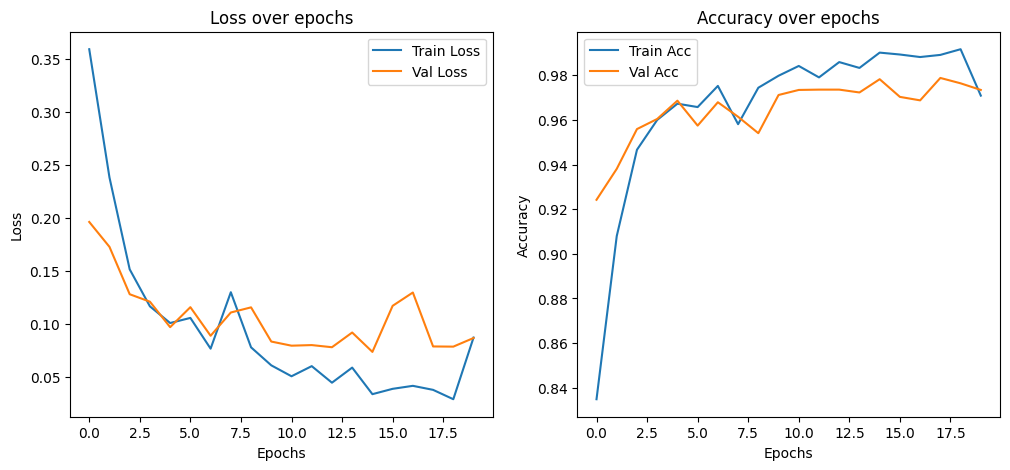

Precisión en el conjunto de prueba: 0.9792


In [12]:
# --------------------
# Entrenamiento y evaluación
# --------------------

# Instanciar modelo, pérdida y optimizador
model = LSTMModel().to(device)
criterion = nn.BCELoss()  # Pérdida para clasificación binaria
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Variables de ntrenamiento
num_epochs = 20
train_losses, valid_losses = [], []
train_accuracies, valid_accuracies = [], []
best_model_path = "models/best_lstm_embeddings.pth"  # Ruta donde se guardará el mejor modelo

# Entrenar el modelo
train_losses, valid_losses, train_accuracies, valid_accuracies = train_model(
    model, train_loader, valid_loader, criterion, optimizer, num_epochs, device, best_model_path
)

# Función para graficar la pérdida y precisión
plot_loss_and_accuracy(train_losses, valid_losses, train_accuracies, valid_accuracies)

# Evaluar el modelo en el conjunto de prueba
evaluate_model(model, test_loader, device)

Aunque el modelo alcanza un **98%** de precisión en el conjunto de prueba, se concluye que no supera el rendimiento de modelos anteriores, a pesar de ser **notablemente más complejo** desde el punto de vista computacional. Sin embargo, aún quedan algunos experimentos adicionales por realizar, los cuales podrían contribuir a mejorar estos resultados en las siguientes etapas.

## Experimentos Adicionales con la LSTM

#### Probando LSTM Bidireccional

Cambio de jugada

In [15]:
# --------------------
# Tokenización y secuencias
# --------------------
# Disponibilidad de GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Usando device: {device}")

# Número máximo de palabras a considerar en el vocabulario
max_words = 10000
# Longitud máxima de las secuencias - La media de longitud de los textos es 1656 aproximadamente
max_len = 1024

# Inicializar el tokenizador de TensorFlow con un vocabulario limitado y un token para palabras 'Out-Of-Vocabulary'
tokenizer = Tokenizer(num_words=max_words, oov_token='<OOV>')
# Ajustar el tokenizador al texto de entrenamiento
tokenizer.fit_on_texts(X_train)

# Convertir textos a secuencias de índices y aplicar padding
X_train_embedding = tokenizer.texts_to_sequences(X_train)
X_train_embedding = pad_sequences(X_train_embedding, maxlen=max_len)
X_valid_embedding = tokenizer.texts_to_sequences(X_valid)
X_valid_embedding = pad_sequences(X_valid_embedding, maxlen=max_len)
X_test_embedding = tokenizer.texts_to_sequences(X_test)
X_test_embedding = pad_sequences(X_test_embedding, maxlen=max_len)

# Convertir a tensores de PyTorch
X_train_tensor = torch.tensor(X_train_embedding, dtype=torch.long).to(device)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).unsqueeze(1).to(device)
X_valid_tensor = torch.tensor(X_valid_embedding, dtype=torch.long).to(device)
y_valid_tensor = torch.tensor(y_valid.values, dtype=torch.float32).unsqueeze(1).to(device)
X_test_tensor = torch.tensor(X_test_embedding, dtype=torch.long).to(device)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).unsqueeze(1).to(device)

print("Shape of X_train_tensor:", X_train_tensor.shape)
print("Shape of y_train_tensor:", y_train_tensor.shape)
print("Shape of X_valid_tensor:", X_valid_tensor.shape)
print("Shape of y_valid_tensor:", y_valid_tensor.shape)
print("Shape of X_test_tensor:", X_test_tensor.shape)
print("Shape of y_test_tensor:", y_test_tensor.shape)

# Batch Size
batch_size = 128

# Crear Datasets & DataLoaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_dataset = TensorDataset(X_valid_tensor, y_valid_tensor)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Usando device: cuda
Shape of X_train_tensor: torch.Size([28283, 1024])
Shape of y_train_tensor: torch.Size([28283, 1])
Shape of X_valid_tensor: torch.Size([7071, 1024])
Shape of y_valid_tensor: torch.Size([7071, 1])
Shape of X_test_tensor: torch.Size([8839, 1024])
Shape of y_test_tensor: torch.Size([8839, 1])


Cambio de jugada

In [18]:
class BiLSTM(nn.Module):
    def __init__(self, input_dim=max_words, embedding_dim=64, hidden_dim_1=64, hidden_dim_2=32):
        super(BiLSTM, self).__init__()
        
        self.embedding = nn.Embedding(
            num_embeddings=input_dim,
            embedding_dim=embedding_dim,
            padding_idx=0
        )
        
        self.bilstm1 = nn.LSTM(
            input_size=embedding_dim,
            hidden_size=hidden_dim_1,
            batch_first=True,
            bidirectional=True
        )
        
        self.bilstm2 = nn.LSTM(
            input_size=hidden_dim_1*2,  # Porque es bidireccional (64 * 2)
            hidden_size=hidden_dim_2,
            batch_first=True,
            bidirectional=True
        )
        
        self.fc1 = nn.Linear(hidden_dim_2 * 2, 16)  # Salida de la segunda BiLSTM
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(16, 1)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        x = self.embedding(x)  # (batch_size, seq_len) → (batch_size, seq_len, 64)
        out, _ = self.bilstm1(x)  # (batch_size, seq_len, 128)
        out, _ = self.bilstm2(out)  # (batch_size, seq_len, 64)
        # Tomamos el último paso de la secuencia
        out = out[:, -1, :]  # (batch_size, 64)
        out = self.fc1(out)
        out = self.relu(out)
        out = self.fc2(out)
        return self.sigmoid(out)  # Para clasificación binaria

🔹 Saved best model at models/best_bilstm.pth (Val Loss: 0.3638)
Epoch [1/20] - Loss: 0.3973 - Acc: 0.8237 - Val Loss: 0.3638 - Val Acc: 0.8610
🔹 Saved best model at models/best_bilstm.pth (Val Loss: 0.1913)
Epoch [2/20] - Loss: 0.2566 - Acc: 0.8950 - Val Loss: 0.1913 - Val Acc: 0.9231
🔹 Saved best model at models/best_bilstm.pth (Val Loss: 0.1192)
Epoch [3/20] - Loss: 0.1346 - Acc: 0.9498 - Val Loss: 0.1192 - Val Acc: 0.9556
🔹 Saved best model at models/best_bilstm.pth (Val Loss: 0.1141)
Epoch [4/20] - Loss: 0.0938 - Acc: 0.9659 - Val Loss: 0.1141 - Val Acc: 0.9634
Epoch [5/20] - Loss: 0.0823 - Acc: 0.9705 - Val Loss: 0.2005 - Val Acc: 0.9245
🔹 Saved best model at models/best_bilstm.pth (Val Loss: 0.1138)
Epoch [6/20] - Loss: 0.0801 - Acc: 0.9730 - Val Loss: 0.1138 - Val Acc: 0.9639
Epoch [7/20] - Loss: 0.0519 - Acc: 0.9832 - Val Loss: 0.2312 - Val Acc: 0.9045
🔹 Saved best model at models/best_bilstm.pth (Val Loss: 0.0729)
Epoch [8/20] - Loss: 0.0567 - Acc: 0.9795 - Val Loss: 0.0729 - 

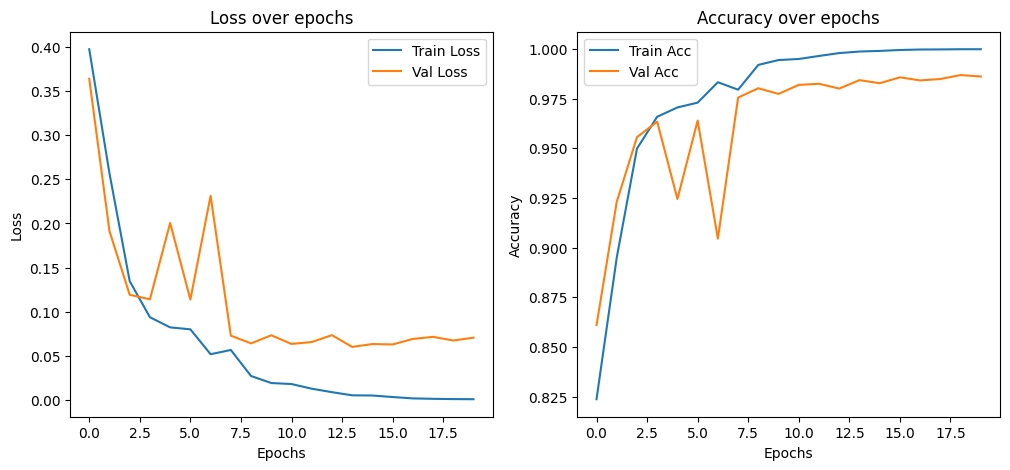

Precisión en el conjunto de prueba: 0.9900


In [22]:
# --------------------
# Entrenamiento y evaluación
# --------------------

# Instanciar modelo, pérdida y optimizador
model = BiLSTM().to(device)
criterion = nn.BCELoss()  # Pérdida para clasificación binaria
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Variables de ntrenamiento
num_epochs = 20
train_losses, valid_losses = [], []
train_accuracies, valid_accuracies = [], []
best_model_path = "models/best_bilstm.pth"  # Ruta donde se guardará el mejor modelo

# Entrenar el modelo
train_losses, valid_losses, train_accuracies, valid_accuracies = train_model(
    model, train_loader, valid_loader, criterion, optimizer, num_epochs, device, best_model_path
)

# Función para graficar la pérdida y precisión
plot_loss_and_accuracy(train_losses, valid_losses, train_accuracies, valid_accuracies)

# Evaluar el modelo en el conjunto de prueba
evaluate_model(model, test_loader, device)

Espectacular Rendimiento de 99% en test

Probar con Batch de 256

## Vectorización mediante Embeddings (*Word2Vec*) + LSTM

✅ **Preserva el orden** de las palabras manteniendo los embeddings en secuencia.

✅ Maneja **diferentes longitudes** de documentos rellenando los más cortos (con padding).

✅ **Eficiente para LSTM** porque cada documento es una matriz de (max_len, vector_size) = (1256, 300), mientras que en las anteriores pruebas nos veíamos obligados a utilizar una *max_len = 1*, porque TF-IDF genera un vector esparso de características (con dim=cantidad de palabras del vocabulario) para cada documento y allMiniLM genera embeddings de dimensiones fijas para cada documento

In [ ]:
# Cargar el DataFrame limpio
df = pd.read_csv("Datasets/Cleaned-FR-News_V2.csv")

# Dividimos los datos en entrenamiento y prueba
# Por ahora usaremos únicamente el texto de la noticia (omitimos el título)
X = df["clean_text"]
y = df["label"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Se usará para redes neuronales
# Usaremos un 20% del conjunto de datos para validación (16% del total)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Tokenize the text data
print("Tokenizing text data...")
X_train_tokens = [simple_preprocess(text) for text in X_train]
X_valid_tokens = [simple_preprocess(text) for text in X_valid]
X_test_tokens = [simple_preprocess(text) for text in X_test]

# Train Word2Vec model on the training data
print("Training Word2Vec model...")
word2vec_model = Word2Vec(
    sentences=X_train_tokens, 
    vector_size=200,   # Dimensionalidad de los vectores
    window=10,         # Mayor contexto
    min_count=5,       # Eliminar palabras raras
    workers=4,         # Usar 4 hilos de CPU
    negative=5         # Mayor velocidad de entrenamiento
)

def encode_text_with_word2vec(tokens_list, model, max_len):
    """
    Convierte una lista de documentos tokenizados en secuencias de embeddings de Word2Vec.

    Parámetros:
    - tokens_list: Lista de documentos tokenizados (lista de listas de palabras).
    - model: Modelo Word2Vec entrenado.
    - max_len: Longitud máxima de la secuencia para el padding.

    Retorna:
    - Un array de NumPy con forma (num_samples, max_len, vector_size)
    """
    embedded_sequences = []
    
    for tokens in tokens_list:
        embeddings = [model.wv[word] for word in tokens if word in model.wv]  # Convertir palabras a vectores
        embedded_sequences.append(embeddings)

    # Rellenar secuencias con ceros para garantizar una forma uniforme
    padded_embeddings = pad_sequences(embedded_sequences, maxlen=max_len, dtype='float32', padding='post', truncating='post', value=0.0)

    return np.array(padded_embeddings)

# Longitud máxima - Teniendo en cuenta que de media tenemos 1656 palabras.
max_len = 500

# Convertir los datos de texto a embeddings de Word2Vec
print("Encoding train text data with Word2Vec...")
X_train_embedding = encode_text_with_word2vec(X_train_tokens, word2vec_model, max_len)
print("Encoding valid text data with Word2Vec...")
X_valid_embedding = encode_text_with_word2vec(X_valid_tokens, word2vec_model, max_len)
print("Encoding test text data with Word2Vec...")
X_test_embedding = encode_text_with_word2vec(X_test_tokens, word2vec_model, max_len)

print("Shape of X_train:", X_train_embedding.shape)
print("Shape of X_valid:", X_valid_embedding.shape)
print("Shape of X_test:", X_test_embedding.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_valid:", y_valid.shape)
print("Shape of y_test:", y_test.shape)

Tokenizing text data...
Training Word2Vec model...
Encoding train text data with Word2Vec...
Encoding valid text data with Word2Vec...
Encoding test text data with Word2Vec...
Shape of X_train: (28283, 500, 200)
Shape of X_valid: (7071, 500, 200)
Shape of X_test: (8839, 500, 200)
Shape of y_train: (28283,)
Shape of y_valid: (7071,)
Shape of y_test: (8839,)


In [ ]:
# GPU disponible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Convertir datos a tensores de PyTorch cuando ya son arrays
def tensorize_w2v(data, labels, device):
    data_tensor = torch.tensor(data, dtype=torch.float32).to(device)
    labels_tensor = torch.tensor(labels.values, dtype=torch.float32).unsqueeze(1).to(device)
    return data_tensor, labels_tensor

X_train_tensor, y_train_tensor = tensorize_w2v(X_train_embedding, y_train, device)
X_valid_tensor, y_valid_tensor = tensorize_w2v(X_valid_embedding, y_valid, device)
X_test_tensor, y_test_tensor = tensorize_w2v(X_test_embedding, y_test, device)

# Create DataLoaders para entrenamiento y validación
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
valid_dataset = TensorDataset(X_valid_tensor, y_valid_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Variables de configuración
batch_size = 128

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

class LSTMModel(nn.Module):
    def __init__(self, input_dim=200, hidden_dim=64):
        super(LSTMModel, self).__init__()
        # Capa LSTM
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        # Dropout para regularización
        self.dropout = nn.Dropout(p=0.3)
        # Capa densa final (64 -> 1) con activación sigmoide
        self.fc = nn.Linear(hidden_dim, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        lstm_out, _ = self.lstm(x)  # Pasamos por la LSTM (48 → 64)
        lstm_out = self.dropout(lstm_out[:, -1, :])  # Tomamos solo el último estado
        out = self.fc(lstm_out)  # Pasamos por la capa densa (64 → 1)
        return self.sigmoid(out)  # Activación sigmoide
    
# Instanciar modelo y moverlo a GPU si está disponible
model = LSTMModel().to(device)

# Función de pérdida y optimizador
criterion = nn.BCELoss()  # Pérdida para clasificación binaria
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Variables de ntrenamiento
num_epochs = 20
train_losses, valid_losses = [], []
train_accuracies, valid_accuracies = [], []

# Ruta donde se guardará el mejor modelo
best_model_path = "models/best_lstm_w2v.pth"  

# Entrenar el modelo
train_losses, valid_losses, train_accuracies, valid_accuracies = train_model(
    model, train_loader, valid_loader, criterion, optimizer, num_epochs, device, best_model_path
)

# Función para graficar la pérdida y precisión
plot_loss_and_accuracy(train_losses, valid_losses, train_accuracies, valid_accuracies)

# Evaluar el modelo en el conjunto de prueba
evaluate_model(model, test_loader, device)

OutOfMemoryError: CUDA out of memory. Tried to allocate 3.29 GiB. GPU 0 has a total capacity of 8.00 GiB of which 0 bytes is free. Of the allocated memory 13.17 GiB is allocated by PyTorch, and 1.86 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)